In [1]:
import matplotlib.pyplot as plt
# from matplotlib import interactive
import numpy as np
import os
import subprocess
import time
import math
from joint_can import *
%matplotlib widget

In [2]:
def save_data(data: np.array, file_path: str, note: str, serial_nr: str, torque: float, temps: list) -> None:
    with open(file_path+'/'+serial_nr+'/'+serial_nr+time.strftime('_%y_%m_%d_%H_%M')+'.txt','w') as file:
        file.write("serial number: " + serial_nr+'\n')
        file.write("torque: "+str(torque)+'\n')
        
        file.write("start_temp: "+str(temps[1][0]) +" ("+str(temps[0][0])+")\n")
        file.write("finish_temp: "+str(temps[1][1]) +" ("+str(temps[0][1])+")\n")
        
        file.write("note: " + note+'\n')
        for line in data:
            file.write(f'{line[0]:.6f} {line[1]:.6f}\n')

In [3]:
def initialize_joint(bus, mode: int):
    send_msg(0x0A0, None, bus)
    time.sleep(1)
    
    send_msg(0x0b0, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x040, None, bus)
    time.sleep(0.1)
    send_msg(0x0a0, None, bus)
    time.sleep(1)
    
    if (send_msg(0x0F0, [mode, 2], bus).data[0] == 1):
        send_msg(0x010, [2], bus)
        time.sleep(1)
        send_msg(0x010, [3], bus).data[0]
        time.sleep(5)
        return True
    else:
        return False
     

Parametry diagnostyki:

In [4]:
const_torque=16. #zadawany moment obrotowy (konieczna kropka na końcu jeżeli jest to liczba całkowita) 16 dla J25, 8 dla J20
serial="JANUSZ_4_RI80_21414852" #musi byc min jedna litera w numerze
note="j4_3_4_ri_80" #póki co musi być cokolwiek
path = "/home/pi/mech_diagnostics/diagnostic_data"

In [5]:
diag_samples = 300 #liczba próbek pozycji (rozdzielczość)
run_duration = 2 #czas trwania diagnostyki w minutach

Ścieżka pliku do wyrysowania:

(Diagnostyka zostanie uruchomiona jedynie gdy target_file="" . Po podaniu nazw plików target_file i ref_file zostanie tylko wyrysowany wykres obu zestawóww danych (diagnostyka nie będzie uruchomiona )

In [6]:
target_file=""

Ścieżka pliku referencyjnego:

In [7]:
ref_file=""

# Ustawienie temperatury

In [8]:
os.popen('/home/pi/mech_diagnostics/can_down.sh')
time.sleep(1)
os.popen('/home/pi/mech_diagnostics/can_up.sh')
time.sleep(1)

bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
initialize_joint(bus,2)

True

parametry temperatury

In [9]:
# parametry rozgrzewki jointa
min_temp = 30
max_temp = 31
speed = 1. #predkosc na ktorej joint jest rozgrzewany

In [10]:
c_speed=0.
j_data=set_speed(c_speed,bus)

while(j_data.bearing_temp<min_temp or j_data.bearing_temp>max_temp):
    if j_data.bearing_temp<min_temp:
        c_speed=speed
    else:
        c_speed=0.
    j_data=set_speed(c_speed,bus)
    print(f'\r tq: {j_data.torque:.3f}\tm_temp: {j_data.motor_temp:.3f}\tb_temp: {j_data.bearing_temp:.3f}', end='')
    time.sleep(1)
send_msg(0x0A0, None, bus)

 tq: 31.543	m_temp: 31.000	b_temp: 30.000

# Diagnostyka

In [11]:
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [12]:
if not len(target_file):
    while not initialize_joint(bus,1):
        print("Joint initialization in progress")


In [13]:
print("Running diagnostics...")
position_bins=np.linspace(0,2*math.pi,diag_samples)
start_time=time.time()
data=[]

motor_temp=[0,0]
bearing_temp=[0,0]

current_reading = set_torque(const_torque,bus)
motor_temp[0] = current_reading.motor_temp
bearing_temp[0] = current_reading.bearing_temp

time.sleep(5)
while((cur_time:=time.time()-start_time)<(run_duration*60)):
    current_reading=set_torque(const_torque,bus)
    print(f'\r Time left: {(math.floor(run_duration-cur_time/60))} min {int((run_duration*60-cur_time)%60)} sec\t\t', end='')
    if np.sign(current_reading.torque) == np.sign(const_torque):
        motor_temp[1] = current_reading.motor_temp
        bearing_temp[1] = current_reading.bearing_temp
        data.append([current_reading.position + math.pi, current_reading.speed])
    else:
        if cur_time>30:
            print("Speed/Torque sign error, aborting.")
            break
    
        
set_torque(0.,bus)

Running diagnostics...
 Time left: 0 min 0 sec			

In [14]:
data = np.array(data)
position_bin_num = np.digitize(data[:,0],position_bins)
binarized_avg_data = np.array([position_bins,np.zeros(diag_samples)]).T
for i in range(diag_samples):
    binarized_avg_data[i,1]=np.mean(data[position_bin_num==i,1])

/home/pi/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pi/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
save_data(binarized_avg_data, path, note, serial, const_torque, [motor_temp, bearing_temp])

# Wykresy

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]

Zakres dopuszczalnej prędkości

In [17]:
# definicja zielonej sekcji na wykresie
ref_v_min=0.25
ref_v_max=0.45
avg_samples = 5  #ilość próbek do uśredniania obliczeń jittera

In [18]:
flist=os.listdir(path+'/'+serial)
flist.sort()
flist.reverse()
ref_data=[]
            
            
for fname in flist:
    if '.txt' not in fname:
        flist.remove(fname)

if len(ref_file):
    rfname=ref_file+'.txt'
    data_points = []
    with open(path+'/'+serial+'/'+rfname) as file:
        ref_data = (list(file))

        if "serial number: " in ref_data[0]:
            rf_serial = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_serial = ''

        if "torque: " in ref_data[0]:
            rf_tq = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_tq = ''

        if "start_temp: " in ref_data[0]:
            rf_temp1 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp1 = ''

        if "finish_temp: " in ref_data[0]:
            rf_temp2 = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_temp2 = ''

        if "note: " in ref_data[0]:
            rf_note = ref_data[0].strip()
            ref_data.remove(ref_data[0])
        else:
            rf_note = ''

        ref_data = [point.split() for point in ref_data]

        ref_data = np.array(ref_data, dtype=float)
        


Wykresy prędkości przy stałym momencie:

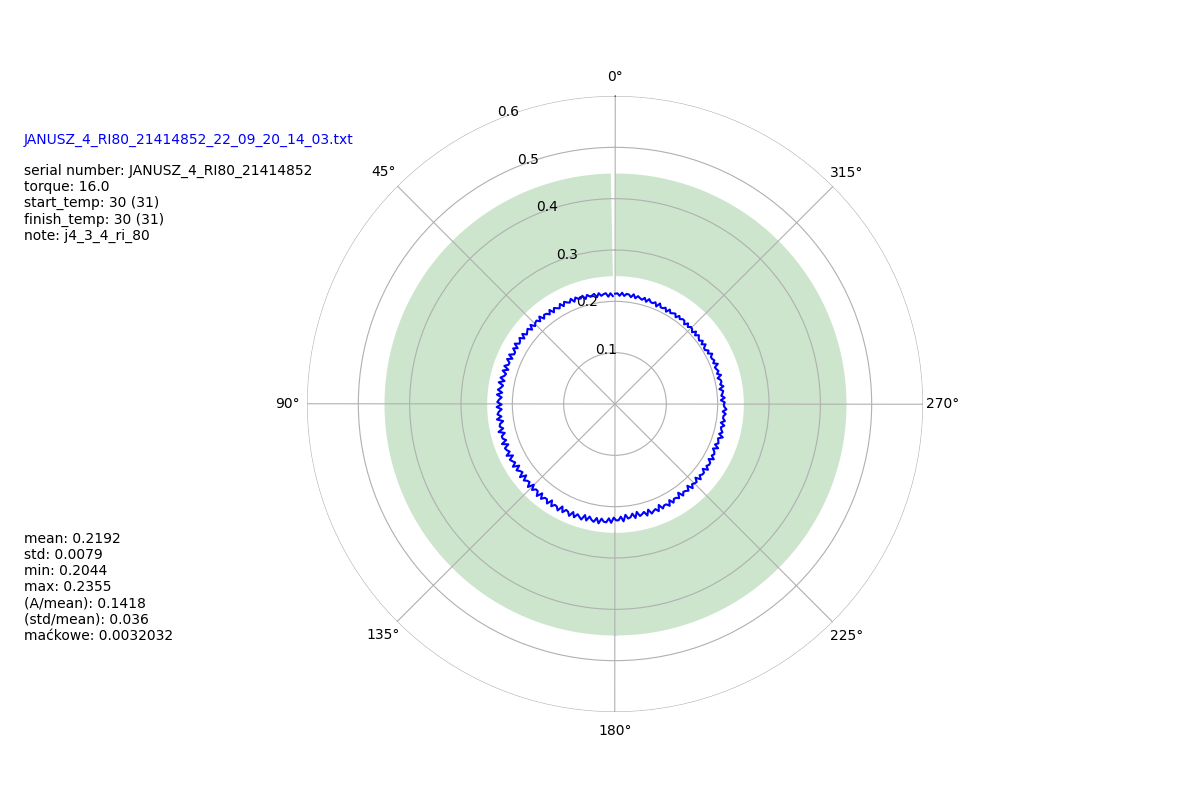

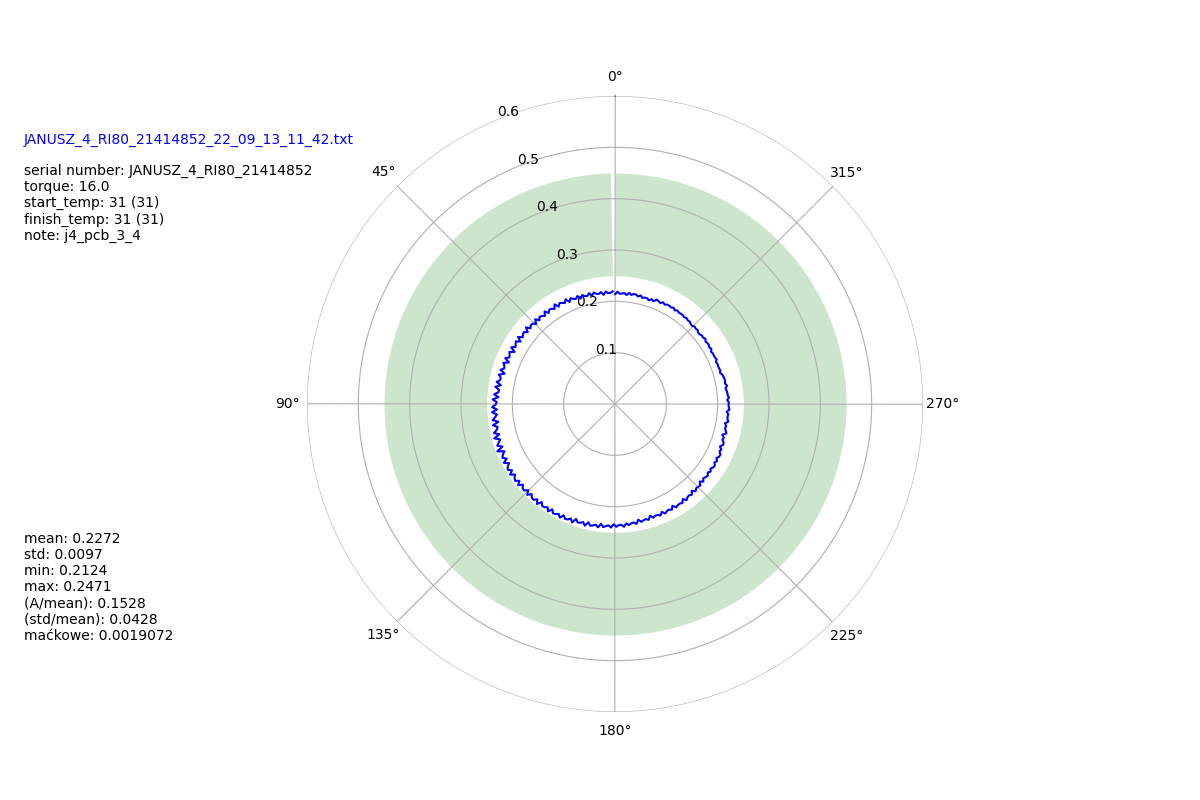

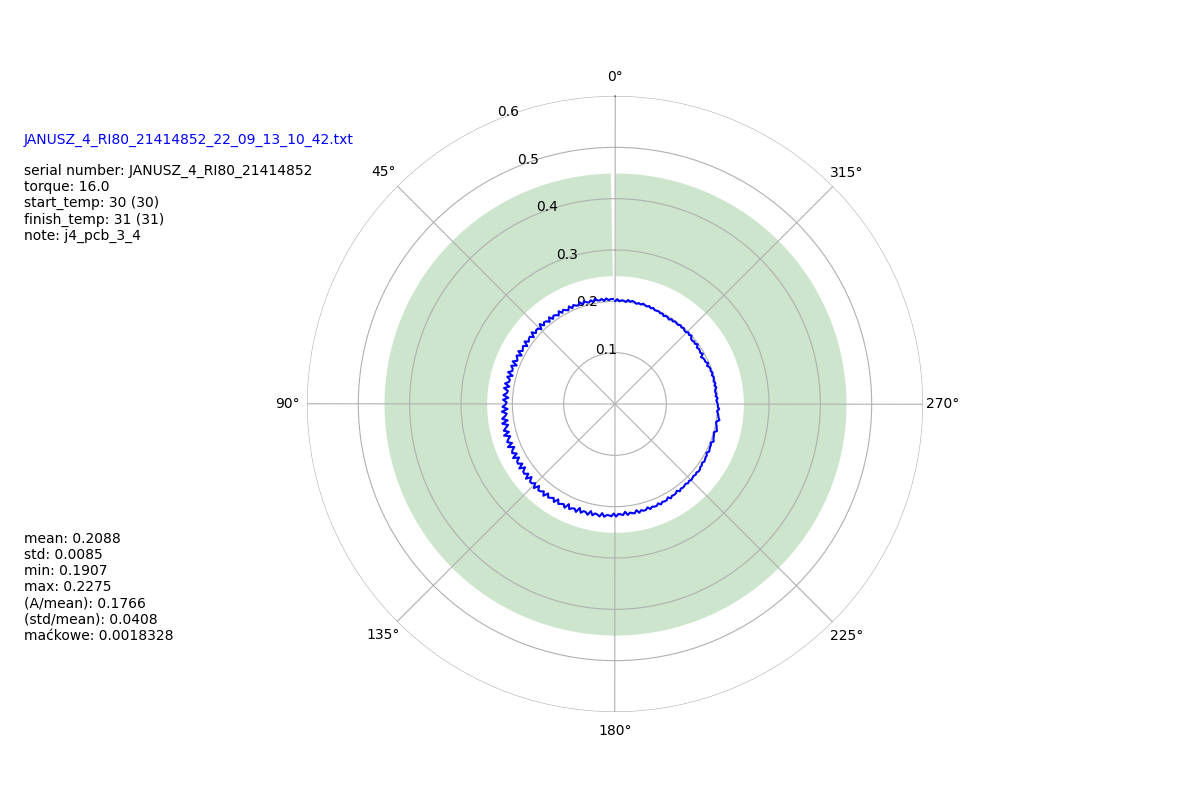

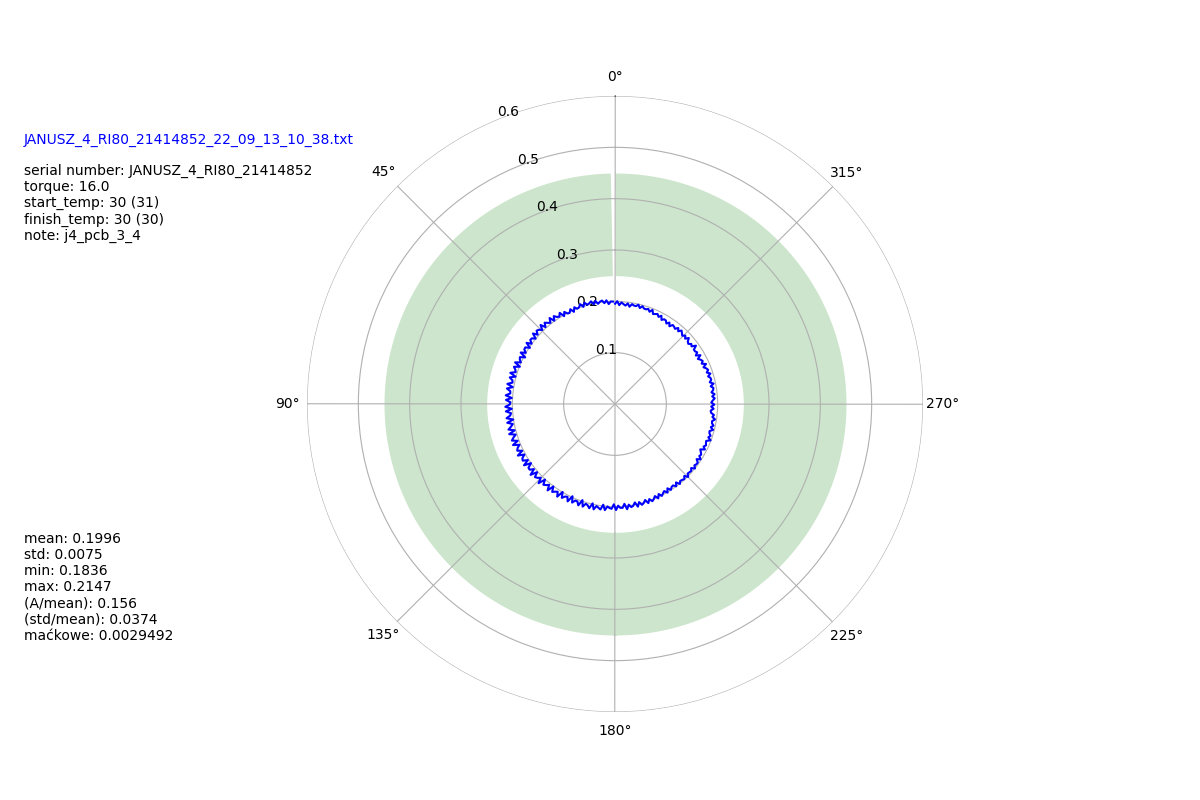

In [19]:
if target_file[-4:]!='.txt':
    target_file=target_file+".txt"

for fname in flist:
    # if len(target_file):
    #     if target_file != fname:
    #         continue
    if serial in fname and '.txt' in fname or fname == target_file:
        data_points = []
        with open(path+'/'+serial+'/'+fname) as file:
            data_points+=(list(file))
            
        f, a = plt.subplots(subplot_kw={'projection': 'polar'})
        f.canvas.manager.set_window_title(fname)
        
        if "serial number: " in data_points[0]:
            r_serial=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_serial=''
            
        if "torque: " in data_points[0]:
            r_tq=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_tq=''
            
        if "start_temp: " in data_points[0]:
            r_temp1=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp1=''
            
        if "finish_temp: " in data_points[0]:
            r_temp2=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_temp2=''
        
        if "note: " in data_points[0]:
            r_note=data_points[0].strip()
            data_points.remove(data_points[0])
        else:
            r_note=''
            
        data_points=[point.split() for point in data_points]
        
        
        data_points=np.array(data_points,dtype=float)
        
        data_points = data_points[~np.isnan(data_points[:,1])]
        
        if len(ref_data):
            a.set_ylim(0,max(0.6,data_points[:,1].max(),ref_data[:,1].max())) #zakres predkosci wykresu
        else:
            a.set_ylim(0,max(0.6,data_points[:,1].max())) #zakres predkosci wykresu
                
        a.set_theta_offset(1.57)
        
        a.plot(data_points[:, 0], data_points[:, 1],color='blue')
        
        a.fill_between(data_points[:,0],ref_v_min,ref_v_max,alpha=0.2,linewidth=0,color='green')
        
        v_min = data_points[:,1].min()
        v_max = data_points[:,1].max()
        v_mean = np.nanmean(data_points[:,1])
        v_std = np.nanstd(data_points[:,1])
        v_A = (v_max-v_min)
        
        v_moving_avg = np.convolve(data_points[:,1],np.ones(avg_samples),'same')/avg_samples
        boundary=int(np.ceil(avg_samples/2))
        v_moving_avg_deviation_mean = np.nanmedian(abs(data_points[:,1]-v_moving_avg)[boundary:-boundary])
        
        # f.suptitle("Joint "+str(fname))
        # a.set_title(str(r_tq)+' '+str(r_temp1)+' '+str(r_temp2))
        plt.figtext(0.02,0.82,str(fname),color = 'blue')
        plt.figtext(0.02,0.7,r_serial+'\n'+r_tq+'\n'+r_temp1+'\n'+r_temp2+'\n'+r_note)
        plt.figtext(0.02,0.2,'mean: '+ str(round(v_mean,4))+'\nstd: '+str(round(v_std,4))+'\nmin: '+ str(round(v_min,4))+'\nmax: '+ str(round(v_max,4))+'\n(A/mean): ' + str(round(v_A/v_mean,4)) + '\n(std/mean): ' + str(round(v_std/v_mean,4))+
                   '\nmaćkowe: ' + str(round(v_moving_avg_deviation_mean,9)))
        
        if len(ref_data):
            a.plot(ref_data[:, 0], ref_data[:, 1],alpha=0.8,color='green')
            plt.figtext(0.78,0.82,str(rfname),color = 'green')
            plt.figtext(0.78,0.7,rf_serial+'\n'+rf_tq+'\n'+rf_temp1+'\n'+rf_temp2+'\n'+rf_note)
            plt.figtext(0.78,0.2,'mean: '+ str(round(np.nanmean(ref_data[:,1]),4))+'\nstd: '+str(round(np.nanstd(ref_data[:,1]),4))+'\nmin: '+ str(round(ref_data[:,1].min(),4))+'\nmax: '+ str(round(ref_data[:,1].max(),4)))
        
        try:
            if len(target_file) and len(ref_data):
                plt.savefig( path+'/'+serial+'/'+fname[:-4] + "_comp.png", dpi=150)
            else:
                plt.savefig( path+'/'+serial+'/'+fname[:-4] + ".png", dpi=150)   
        except PermissionError:
                print(f"Brak pozwolenia na nadpisanie pliku {fname}")